# Revisiting the unfinished K-function analysis

This time using the webpage cited in the Levayer paper which I ended up finding on web archive.

https://web.archive.org/web/20210513032304/https://www.seas.upenn.edu/~ese502/

#### Analysis of point patterns

If I see a case of local clustering, I have to ask how likely it is that this case could simply be a coincidence. To do so, I must model the probability of local clustering patterns. I will begin by asking what would the point patterns look like if points were randomly distributed. This requires a statistical model of randomly located points. 

##### Spatial Laplace Principle

The Laplce Principle of probability theory asserts that if there is no information to indicate that either of two events is more likely, then they should be treated as equally likely, i.e., as having the same probability of occuring. 
To develop a model of randomly located points, consider a region square of S, divide it up into halves, then the probability of finding an event in one half is 1/2. Continue doing so until you have S divided up into a grid of N cells, each with the same probability of 1/N of finding an event in that region. 
Considering a subregion of S, C (a cell), the probability that C will contain the event point is at least as large as the sum of probabilities of all cells _inside_ C and is no greater than the sum of probabilities of cells that _intersect_ C. Hence, by allowing n to become arbitrarily large, it is evident that these two sums will converge to the same limit, i.e. the fractional area of S inside C. Hence the probability Pr(C|S) that a random point in S lies in any cell C (belong to) S is proportional to the area of C^2. This must hold for any pair of nested regions C, R, S, (derivation online), resulting in the Spatial Laplace Principle. 

*Complete Spatial Randomness (dervied online)*

"However, as was noted in the Housing Abandonment example above, simple area may
not always be the most relevant reference measure (backcloth). In particular, while one
can imagine a randomly located abandoned house, such houses are very unlikely to
appear in the middle of a public park, let alone the middle of a street. So here it makes
much more sense to look at the existing housing distribution, and to treat a “randomly
located abandoned house” as a random sample from this distribution. Here the Laplace
principle is still at work, but now with respect to houses. For if housing abandonments
are spatially random, then each house should have that same chance of being abandoned.
Similarly, in the Larynx cancer example, if such cancers are spatially random, then each
individual should have the same chance of contracting this disease. So here, the existing
population distribution becomes the relevant reference measure. "

Think about this example with regard to division events only happening in areas where there are cells anyway.


#### Ripley's correction

A method for avoiding edge effects whilst not creating a buffer zone and throwing away valuable data (see more in section 4.3)

# Testing Spatial Randomness

3.3 Redwood seedling example 
(with my own data)
 
First with xy data, then will try R,t

In [71]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

List of cell instances

In [2]:
fn = '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0806_Pos3_Scr_-12_N_cells_wt_rad_1600_t_range_1600_focal_txy_870_208_461.csv'

In [9]:
focal_t, focal_x, focal_y = 870, 208, 461

List of division events

In [25]:
fn = '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0796_Pos7_Scr_-5_N_events_wt_rad_1600_t_range_1600_focal_txy_204_755_269.csv'

In [109]:
focal_t, focal_x, focal_y = 204, 755, 269

In [33]:
df = pd.read_csv(fn, names=['Cell ID', 'Distance', 'Frame', 'x', 'y'])

In [34]:
## tidy up df and convert from pixels and frames to aligned time and um
df['Cell ID'] = df['Cell ID'].str.replace('[()]', '')
df['y'] = df['y'].str.replace('[()]', '')
df['Distance'] = round(df['Distance']/3)
df['x'] = round(df['x'].astype(int)/3)
df['y'] = round(df['y'].astype(int)/3)
df['Time'] = round((df['Frame'] - focal_t)*(4/60), 3)

<ipython-input-34-f3edf9962f42>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Cell ID'] = df['Cell ID'].str.replace('[()]', '')
<ipython-input-34-f3edf9962f42>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['y'] = df['y'].str.replace('[()]', '')


In [35]:
df

,Cell ID,Distance,Frame,x,y,Time
0,80,227.0,477,207.0,312.0,18.200
1,79,215.0,262,48.0,159.0,3.867
2,78,374.0,79,25.0,378.0,-8.333
3,77,335.0,213,13.0,325.0,0.600
4,75,298.0,97,45.0,294.0,-7.133
...,...,...,...,...,...,...
876,3934,158.0,940,397.0,151.0,49.067
877,4061,256.0,970,2.0,36.0,51.067
878,4066,484.0,963,56.0,532.0,50.600
879,4085,147.0,986,398.0,83.0,52.133


Mean NN distance

In [86]:
### lambda_d = estimated point density 
### lambda_d = n/a(R)
### n = number of data points
### a = a(R) = area of complete region (FOV)
n = len(df)
a = (1200/3) * (1600/3)
lambda_d = n/a
print('Area and number of counts are (respectively):', a, n)
print('Estimated point density for this experiment is:', lambda_d)

Area and number of counts are (respectively): 213333.33333333334 881
Estimated point density for this experiment is: 0.0041296875


Assuming m = n (i.e. the number of subcells/quadrats that we partition R into), the corresponding estimates of the mean and standard deviation of nn-distances under Complete Spatial Randomness are given by

In [88]:
mean_nn_csr = 1/(2*np.sqrt(lambda_d))
print('Mean value under CSR:', mean_nn_csr, 'micrometers')
st_dev_nn_csr = np.sqrt((4-np.pi)/(n*4*np.pi*lambda_d))
print('Standard deviation under CSR:', st_dev_nn_csr)

Mean value under CSR: 7.780569918442348 micrometers
Standard deviation under CSR: 0.13702355538616814


These are the theoretical values showing the average distance (and st.dev.) between division events assuming complete spatial randomness. **However this is over all time...**

Continuing regardless, I will calculate a mean nn-distance for the time-independent division event dataset to see if it is different from the CSR hypothesis. 

In [90]:
from itertools import combinations

def dist(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

x = df['x']
y = df['y']

points = list(zip(x,y))
### average distances between all points, not just nearest neighbours
# distances = [dist(p1, p2) for p1, p2 in combinations(points, 2)]
# avg_distance = sum(distances) / len(distances)
nearest_neighbours = []
for p1 in tqdm(points):
    nearest_neighbours.append(np.min([dist(p1, p2) for p2 in points if p2 != p1]))
df['NN distance'] = nearest_neighbours
avg_NN_distance = np.mean(df['NN distance'])
print('Average nearest-neighbour distance between time independent division events:', avg_NN_distance)

  0%|          | 0/881 [00:00<?, ?it/s]

Average nearest-neighbour distance between time independent division events: 7.81563487050898


Given that the observed average distance is very similar to the hypothetical case of CSR, this suggests that the division events are close enough to the CSR case to be random. To verify this statistically, let us compute the standardized mean.

In [91]:
### standardised mean is written as Z_mean
Z_mean = (avg_NN_distance - mean_nn_csr)/st_dev_nn_csr
print('Standardised mean is:', Z_mean)

Standardised mean is: 0.25590455573722176


A significant clustering is evident if 

`Z_mean <= -|Z_alpha|`

and (I think) a significant dispersion is evident if

`Z_mean >= |Z_alpha|`

The strength of significance depends on the alpha values chosen according to this table

| Significance | alpha | Z_alpha|
|--------------|-------|------|
| Strong       | 0.01  | 2.33 |
| Standard     | 0.05  | 1.65 |
| Weak         | 0.10  | 1.28 |

Relating this back to my data suggests the distribution of division points over all time is not showing any significant clustering or dispersion over all time, something one would expect given it is a time-dependent phenomena occuring over many, many hours. I will calculate a p-value for this when I come across it later in the chapter.

# Repeating for a (r, t) distance from apoptosis

Mean NN distance

In [98]:
### lambda_d = estimated point density 
### lambda_d = n/a(R)
### n = number of data points
### a = a(R) = area of complete region (FOV)
n = len(df)
a = (1600/3)*(1600*(4/60)) #(1200/3) * (1600/3)
lambda_d = n/a
print('Area and number of counts are (respectively):', a, n)
print('Estimated point density for this experiment is:', lambda_d)

Area and number of counts are (respectively): 56888.8888888889 881
Estimated point density for this experiment is: 0.015486328124999997


Assuming m = n (i.e. the number of subcells/quadrats that we partition R into), the corresponding estimates of the mean and standard deviation of nn-distances under Complete Spatial Randomness are given by

In [99]:
mean_nn_csr = 1/(2*np.sqrt(lambda_d))
print('Mean value under CSR:', mean_nn_csr, 'micrometers')
st_dev_nn_csr = np.sqrt((4-np.pi)/(n*4*np.pi*lambda_d))
print('Standard deviation under CSR:', st_dev_nn_csr)

Mean value under CSR: 4.017869029083949 micrometers
Standard deviation under CSR: 0.07075865973983451


These are the theoretical values showing the average distance (and st.dev.) between division events assuming complete spatial randomness. **However this is over all time...**

Continuing regardless, I will calculate a mean nn-distance for the time-independent division event dataset to see if it is different from the CSR hypothesis. 

In [100]:
from itertools import combinations

def dist(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

x = df['Distance']
y = df['Time']

points = list(zip(x,y))
### average distances between all points, not just nearest neighbours
# distances = [dist(p1, p2) for p1, p2 in combinations(points, 2)]
# avg_distance = sum(distances) / len(distances)
nearest_neighbours = []
for p1 in tqdm(points):
    nearest_neighbours.append(np.min([dist(p1, p2) for p2 in points if p2 != p1]))
df['NN distance'] = nearest_neighbours
avg_NN_distance = np.mean(df['NN distance'])
print('Average nearest-neighbour distance between time independent division events:', avg_NN_distance)

  0%|          | 0/881 [00:00<?, ?it/s]

Average nearest-neighbour distance between time independent division events: 2.829653099007175


Given that the observed average distance is very similar to the hypothetical case of CSR, this suggests that the division events are close enough to the CSR case to be random. To verify this statistically, let us compute the standardized mean.

In [101]:
### standardised mean is written as Z_mean
Z_mean = (avg_NN_distance - mean_nn_csr)/st_dev_nn_csr
print('Standardised mean is:', Z_mean)

Standardised mean is: -16.79251606016291


A significant clustering is evident if 

`Z_mean <= -|Z_alpha|`

and (I think) a significant dispersion is evident if

`Z_mean >= |Z_alpha|`

The strength of significance depends on the alpha values chosen according to this table

| Significance | alpha | Z_alpha|
|--------------|-------|------|
| Strong       | 0.01  | 2.33 |
| Standard     | 0.05  | 1.65 |
| Weak         | 0.10  | 1.28 |

Relating this back to my data suggests the distribution of division (r,t) over all time **is showing a significant clustering over all time.*** However, I am unsure if I can just substitute the x,y dimensions for r,t like I have. I will either deny or confirm this when I visit the space-time chapter in a little while. Again, I will calculate a p-value when it is discussed later in the chapter. 

In order to assess clustering or dispersion over different scales, we introduce 
# K-Function Analysis of Point Patterns
that allows 'scale' to become a fundamental variable in the analysis. If one to analyse, using the previous nearest neighbour technique, a set of data that was locally clustered but globally dispersed then it would only pick up the prior clustering features. There is no way to analyse multiple scales using NN approach without some form of re-aggregation of the dataset (i.e. classifying one cluster as a single data point). Recall that the quadrat method was criticized for being too dependent on the
scale of individual cells. Hence the key idea of K-functions is to turn this dependency into a virtue by explicitly incorporating “scale” as a variable in the analysis. Thus, rather
than fixing the scale and locations of cell grids, we now consider randomly sampled cells
of varying sizes. Thus, we consider for a given point process with density lambda_d: What is the expected number of point events within distance h from any randomly sampled point event? If we divide this by lambda_d then we eliminate any obvious "density effects", resulting in the K-Function of

`K(h) = 1/lambda_d * E(number of additional events within distance, h, of an arbitrary event)`

Assuming that edge effects are ignored (revisit later as Ripley's correction) the K-function reduces simply to area under the CSR hypothesis. 

In [103]:
### for a circle of radius, h, 100 micrometres
h = 100
Kh = np.pi*h**2 
print('K-function assuming CSR for 100 micrometre radius:', Kh)

K-function assuming CSR for 100 micrometre radius: 31415.926535897932


When `K(h) > np.pi * h**2` this implied a mean point count higher than would be expected under CSR and indicates some degree of clustering at scale h. If it is lower than the CSR case then it indicates some degree of dispersion at scale h. (L functions serve to elimiante the need for considering the above values, meaning that an L(h) value above 0 indicates clustering at scale h, whereas below indicates dispersion at scale h, see below).

# Estimation of the actual K-function

For any distance h we define the indicator function Ih for point pairs as 

`I(dij) = 1 if dij < h, 0 if dij > h`

Then the K-function can now be defined as 

`Kh = 1/lambda_d * E[np.sum(I(dij))]`

Calculating this based on the xy coords of the number of division events, as previously done:

In [104]:
### lambda_d = estimated point density 
### lambda_d = n/a(R)
### n = number of data points
### a = a(R) = area of complete region (FOV)
n = len(df)
a = (1200/3) * (1600/3)
lambda_d = n/a
print('Area and number of counts are (respectively):', a, n)
print('Estimated point density for this experiment is:', lambda_d)

Area and number of counts are (respectively): 213333.33333333334 881
Estimated point density for this experiment is: 0.0041296875


In [105]:
x = df['x']
y = df['y']
points = list(zip(x,y))
### p1 is a given point event 's' 
### will take to be the apoptoses location (converted to micrometres)
p1 = focal_x/3, focal_y/3
### h is the distance of scan area
h = 100

In [187]:
p1 = focal_x/3, focal_y/3
N_events_within_h = len([dist(p1, p2) for p2 in points if dist(p1, p2) <= h])
### can also be calculated as below
##len([distance for distance in df['Distance'] if distance <= h])

In [141]:
Kh = (1/lambda_d) * N_events_within_h
print('K(100) is:', Kh, 'which seems high, but is correct for a temporally incorrect analogy')

K(100) is: 32690.12485811578 which seems high, but is correct for a temporally incorrect analogy


In [173]:
def Kh(h):
    return ((1/lambda_d)* len([distance for distance in df['Distance'] if distance <= h]))
    #return ((1/lambda_d)* len([dist(p1, p2) for p2 in points if dist(p1, p2) <= h]))

In [147]:
print('K(h), h for a range of different h values')
[(Kh(h), h) for h in  range(10, 200, 10)]

K(h), h for a range of different h values


[(0.0, 10),
 (1210.7453651153994, 20),
 (3390.087022323118, 30),
 (5811.577752553917, 40),
 (7748.770336738556, 50),
 (11623.155505107834, 60),
 (16950.435111615592, 70),
 (20582.67120696179, 80),
 (26152.099886492626, 90),
 (32690.12485811578, 100),
 (35838.06280741582, 110),
 (40196.74612183126, 120),
 (44313.28036322362, 130),
 (48914.112750662134, 140),
 (55694.28679530837, 150),
 (62474.460839954605, 160),
 (66348.84600832389, 170),
 (70707.52932273933, 180),
 (76034.80892924708, 190)]

Therefore the L(h) function, defined as 

`L(h) = np.sqrt(K(h)/np.pi) - h`

which if L(h) > 0 indicates clustering at scale h and if L(h) < 0 at scale h indicates dispersion

In [193]:
def Lh(h):
    return np.sqrt(Kh(h)/np.pi) - h

In [150]:
print('L(h), h for a range of different h values')
[(Lh(h), h) for h in  range(10, 200, 10)]

L(h), h for a range of different h values


[(-10.0, 10),
 (-0.36859099892636493, 20),
 (2.8496303514791137, 30),
 (3.010262181991955, 40),
 (-0.3360271026211308, 50),
 (0.8256960989956497, 60),
 (3.454006501647612, 70),
 (0.9423728911278744, 80),
 (1.2385441484934745, 90),
 (2.0077934420735346, 100),
 (-3.193587770789378, 110),
 (-6.884918410501783, 120),
 (-11.234031689005633, 130),
 (-15.220812382655865, 140),
 (-16.853306121023024, 150),
 (-18.981424913738266, 160),
 (-24.674525215516923, 170),
 (-29.97698306240406, 180),
 (-34.42805080518238, 190)]

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()
sns.set_style('whitegrid')

Text(0.5, 1.0, 'L-function for a series of division events \naround a single apoptosis')

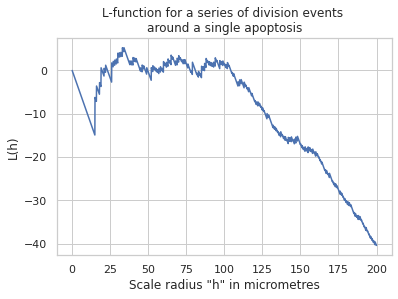

In [176]:
h_ = np.linspace(0, 200, num = 2000)
sns.lineplot( x = h_, y = [Lh(h) for h in h_])
plt.xlabel('Scale radius "h" in micrometres')
plt.ylabel('L(h)')
plt.title(f'L-function for a series of division events \naround a single apoptosis')

Now how do we incorporate edge effects into this example? Need a suitably random distribution of events and to calculate the L(h) function for that, then overlay the two. 

In [184]:
import random

x_rand = []
y_rand = []
for _ in range(n):
    x_rand.append(random.randint(0, 1201))
    y_rand.append(random.randint(0, 1601))
    
rand_points = list(zip(x_rand, y_rand))

In [185]:
rand_points

[(260, 661),
 (895, 1327),
 (393, 787),
 (1102, 822),
 (942, 840),
 (574, 1136),
 (389, 885),
 (1165, 115),
 (653, 1393),
 (1041, 1210),
 (1026, 973),
 (751, 1473),
 (141, 1230),
 (479, 986),
 (13, 1108),
 (1196, 1254),
 (1017, 1215),
 (807, 37),
 (1078, 871),
 (845, 456),
 (1179, 1058),
 (643, 491),
 (1057, 1585),
 (879, 676),
 (187, 782),
 (20, 474),
 (667, 22),
 (485, 502),
 (598, 378),
 (822, 1515),
 (522, 839),
 (3, 401),
 (975, 225),
 (492, 1222),
 (844, 1206),
 (918, 346),
 (1027, 618),
 (1132, 1447),
 (1153, 445),
 (289, 1599),
 (1178, 583),
 (550, 1021),
 (104, 471),
 (700, 1275),
 (202, 824),
 (81, 177),
 (625, 169),
 (902, 421),
 (107, 935),
 (791, 1157),
 (1004, 74),
 (713, 1125),
 (317, 1570),
 (572, 1180),
 (1120, 873),
 (276, 23),
 (300, 1356),
 (1135, 1493),
 (835, 1470),
 (416, 811),
 (772, 171),
 (1155, 1068),
 (921, 785),
 (315, 822),
 (313, 1079),
 (966, 1458),
 (234, 453),
 (175, 356),
 (612, 1090),
 (1188, 1152),
 (851, 671),
 (1201, 1374),
 (936, 864),
 (181, 959

In [192]:
### lambda_d will be the same as same n being used and same area
### p1 will be the same (focal apoptotic point)
### redefining Kh and Lhto use new random data
def rand_Kh(h):
    return ((1/lambda_d)* len([dist(p1, p2) for p2 in rand_points if dist(p1, p2) <= h]))
def rand_Lh(h):
    return np.sqrt(rand_Kh(h)/np.pi) - h

Text(0.5, 1.0, 'L-function for a series of random events \naround a single apoptosis')

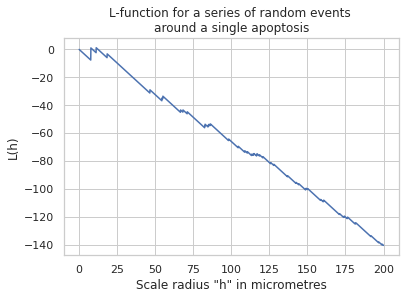

In [196]:
h_ = np.linspace(0, 200, num = 2000)
sns.lineplot( x = h_, y = [rand_Lh(h) for h in h_])
plt.xlabel('Scale radius "h" in micrometres')
plt.ylabel('L(h)')
plt.title(f'L-function for a series of random events \naround a single apoptosis')

Text(0.5, 1.0, 'L-function overlay for a series of random and division events \naround a single apoptosis')

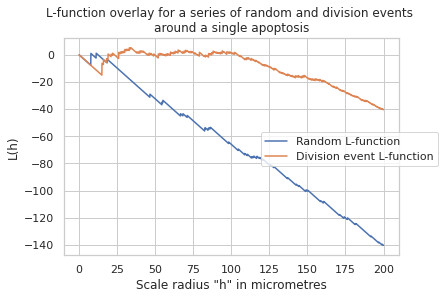

In [206]:
fig, ax = plt.subplots()
sns.lineplot( x = h_, y = [rand_Lh(h) for h in h_], ax = ax)
sns.lineplot( x = h_, y = [Lh(h) for h in h_], ax = ax)
plt.xlabel('Scale radius "h" in micrometres')
plt.ylabel('L(h)')
fig.legend(labels=['Random L-function','Division event L-function'], loc = 5)
plt.title(f'L-function overlay for a series of random and division events \naround a single apoptosis')

The overlay of a random L-function plot with the division event L-function indicates that for the most part the L-function is above the random case, which points to relative dispersion of division events in the immediate local environment of h < 20, and then a generalised clustering of events beyond that. INTERESTING. Or is it? Hold yer horses.
As a reminder, if L(h) > 0 that indicates clustering at scale h and if L(h) < 0 at scale h indicates dispersion.
This makes sens as the immediate local environment where h < 15 is likely occupied by the central apoptotic focal cell, which is reflected in the division event L-function and not in the random control plot. 

Text(0.5, 1.0, 'L-function above random for a series of division events \naround a single apoptosis')

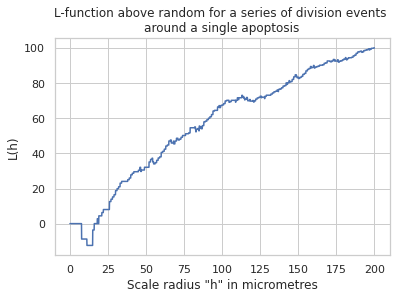

In [209]:
h_ = np.linspace(0, 200, num = 2000)
sns.lineplot( x = h_, y =[Lh(h) - rand_Lh(h) for h in h_])
plt.xlabel('Scale radius "h" in micrometres')
plt.ylabel('L(h)')
plt.title(f'L-function above random for a series of division events \naround a single apoptosis')

But observe even these benchmark comparisons have
little meaning at scales so large that circles of radius h around all pattern points lie
mostly outside the relevant region R (the FOV). For this reason, the commonly accepted rule-ofthumb is that for any given point pattern, n S , one should not consider h-values larger
that half the maximum pairwise distance between pattern points.

In [210]:
### maximum pairwise distance between pattern points
hmax = np.max(df['Distance'])
h_hat = hmax/2

#### Was my random simulation of points truly accurate?

Or can I use a Poission distribution?

In [222]:
from skimage.io import imshow

In [236]:
poisson = np.random.poisson(lam = lambda_d, size = (int(1200/3), int(1600/3)))

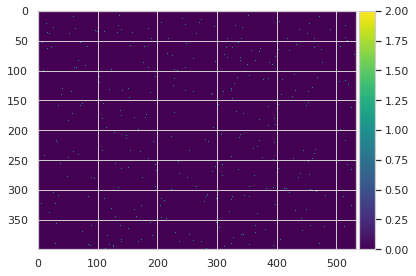

In [246]:
imshow(poisson)

In [247]:
ii = np.nonzero(poisson)

In [248]:
len(ii[0])

875

In [254]:
pois_rand_points = tuple(zip(*ii))

In [255]:
### lambda_d will be different as diff n
n_pois = len(pois_rand_points)
lambda_d_pois = n_pois/a
### p1 will be the same (focal apoptotic point)
### redefining Kh and Lhto use new random data
def pois_rand_Kh(h):
    return ((1/lambda_d_pois)* len([dist(p1, p2) for p2 in pois_rand_points if dist(p1, p2) <= h]))
def pois_rand_Lh(h):
    return np.sqrt(pois_rand_Kh(h)/np.pi) - h

Text(0.5, 1.0, 'L-function for a series of random events \naround a single apoptosis')

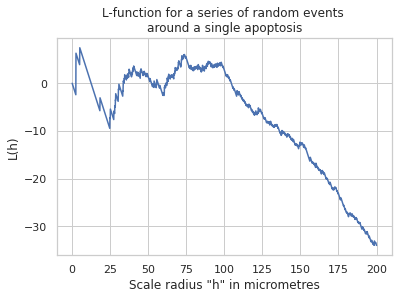

In [256]:
h_ = np.linspace(0, 200, num = 2000)
sns.lineplot( x = h_, y = [pois_rand_Lh(h) for h in h_])
plt.xlabel('Scale radius "h" in micrometres')
plt.ylabel('L(h)')
plt.title(f'L-function for a series of random events \naround a single apoptosis')

Text(0.5, 1.0, 'L-function overlay for a series of random and division events \naround a single apoptosis')

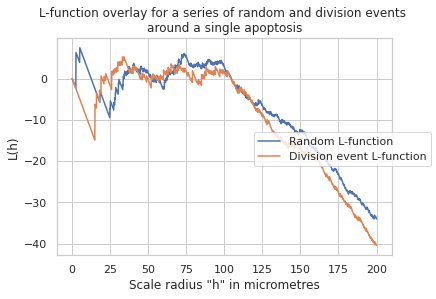

In [257]:
fig, ax = plt.subplots()
sns.lineplot( x = h_, y = [pois_rand_Lh(h) for h in h_], ax = ax)
sns.lineplot( x = h_, y = [Lh(h) for h in h_], ax = ax)
plt.xlabel('Scale radius "h" in micrometres')
plt.ylabel('L(h)')
fig.legend(labels=['Random L-function','Division event L-function'], loc = 5)
plt.title(f'L-function overlay for a series of random and division events \naround a single apoptosis')

The overlay of a random L-function plot with the division event L-function indicates that for the most part the L-function is inline with the Poisson random case. There is a similar indication of relative dispersion in the immediate environment whereas a stronger case for clustering in the 15-30 local neighbourhood. There is also not a strong indication of clustering or dispersion of events beyond that. INTERESTING.

Text(0.5, 1.0, 'L-function above random for a series of division events \naround a single apoptosis')

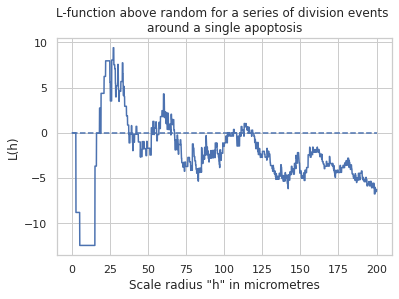

In [262]:
h_ = np.linspace(0, 200, num = 2000)
sns.lineplot( x = h_, y =[Lh(h) - pois_rand_Lh(h) for h in h_])
plt.xlabel('Scale radius "h" in micrometres')
plt.ylabel('L(h)')
plt.hlines(y = 0, xmin = 0, xmax =200, linestyles='dashed')
plt.title(f'L-function above random for a series of division events \naround a single apoptosis')

#### Plotting upper and lower envelopes for non-Poisson randomness

First simulate N random patterns i. Let N = 99. 
Then choose a selection of h-values and compute Lh for each value of h and i. Form the lower and upper envelope functions by considering the min and the max of the calculated Lh. Plot the L-values for the upper and lower. 

In [319]:
N_random_patterns = {}
n = len(df)
for i in tqdm(range(1000)):
    x_rand = []
    y_rand = []
    for _ in range(n):
        x_rand.append(random.randint(0, 1201))
        y_rand.append(random.randint(0, 1601))

    rand_points = list(zip(x_rand, y_rand))
   
    N_random_patterns[i] = rand_points

  0%|          | 0/1000 [00:00<?, ?it/s]

In [279]:
def env_rand_Kh(h, env_rand_points, lambda_d_env):
    return ((1/lambda_d_env)* len([dist(p1, p2) for p2 in env_rand_points if dist(p1, p2) <= h]))
def env_rand_Lh(h, env_rand_points, lambda_d_env):
    return np.sqrt(env_rand_Kh(h, env_rand_points, lambda_d_env)/np.pi) - h

In [280]:
h_ = np.linspace(0, 200, 100)

In [320]:
Lh_env_i = {}
for i in tqdm(range(1000)):
    env_rand_points = N_random_patterns[i]
    n_env = len(env_rand_points)
    lambda_d_env = n_env/a
 
    Lh_env = [env_rand_Lh(h, env_rand_points, lambda_d_env) for h in h_]
    Lh_env_i[i] = Lh_env
    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [321]:
min_Lh, max_Lh = [], []
for n, h in enumerate(h_):
    vals = []
    for i in range(1000):
        vals.append(Lh_env_i[i][n])
    min_Lh.append(np.min(vals))
    max_Lh.append(np.max(vals))
    

Text(0.5, 1.0, 'Minimum, Maximum and observed L-function overlay for division events \naround a single apoptosis')

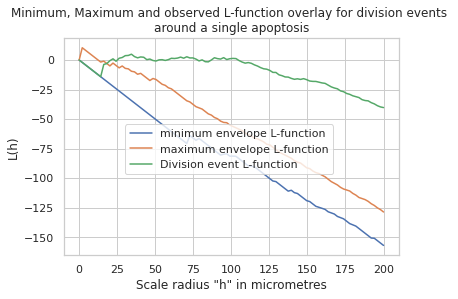

In [322]:
fig, ax = plt.subplots()
sns.lineplot( x= h_, y =min_Lh)
sns.lineplot( x= h_, y =max_Lh)
sns.lineplot( x = h_, y =[Lh(h) for h in h_])
plt.xlabel('Scale radius "h" in micrometres')
plt.ylabel('L(h)')
fig.legend(labels=['minimum envelope L-function','maximum envelope L-function','Division event L-function'], loc = 10)
plt.title(f'Minimum, Maximum and observed L-function overlay for division events \naround a single apoptosis')

#### Plotting upper and lower envelopes for Poisson distribution of random points

First simulate N random patterns i. Let N = 99. 
Then choose a selection of h-values and compute Lh for each value of h and i. Form the lower and upper envelope functions by considering the min and the max of the calculated Lh. Plot the L-values for the upper and lower. 

In [323]:
N_random_patterns = {}
### range is the number of simulations of random data coordinates
for i in tqdm(range(1000)):
    poisson = np.random.poisson(lam = lambda_d, size = (int(1200/3), int(1600/3)))
    ii = np.nonzero(poisson)
    N_random_patterns[i] = tuple(zip(*ii))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [279]:
def env_rand_Kh(h, env_rand_points, lambda_d_env):
    return ((1/lambda_d_env)* len([dist(p1, p2) for p2 in env_rand_points if dist(p1, p2) <= h]))
def env_rand_Lh(h, env_rand_points, lambda_d_env):
    return np.sqrt(env_rand_Kh(h, env_rand_points, lambda_d_env)/np.pi) - h

In [280]:
h_ = np.linspace(0, 200, 100)

In [324]:
Lh_env_i = {}
for i in tqdm(range(1000)):
    env_rand_points = N_random_patterns[i]
    n_env = len(env_rand_points)
    lambda_d_env = n_env/a
 
    Lh_env = [env_rand_Lh(h, env_rand_points, lambda_d_env) for h in h_]
    Lh_env_i[i] = Lh_env
    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [325]:
min_Lh, max_Lh = [], []
for n, h in enumerate(h_):
    vals = []
    for i in range(99):
        vals.append(Lh_env_i[i][n])
    min_Lh.append(np.min(vals))
    max_Lh.append(np.max(vals))
    

Text(0.5, 1.0, 'Minimum, Maximum and observed L-function overlay for division events \naround a single apoptosis')

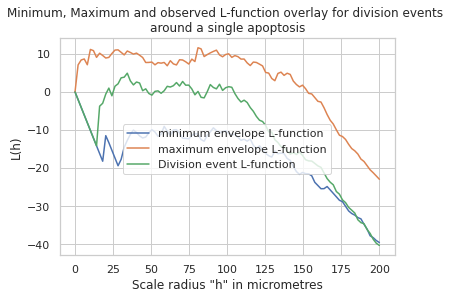

In [326]:
fig, ax = plt.subplots()
sns.lineplot( x= h_, y =min_Lh)
sns.lineplot( x= h_, y =max_Lh)
sns.lineplot( x = h_, y =[Lh(h) for h in h_])
plt.xlabel('Scale radius "h" in micrometres')
plt.ylabel('L(h)')
fig.legend(labels=['minimum envelope L-function','maximum envelope L-function','Division event L-function'], loc = 10)
plt.title(f'Minimum, Maximum and observed L-function overlay for division events \naround a single apoptosis')

#### Tomorrow: attempt Comparative Analyses of Point Patterns and Space-Time K-function